# Notebook 5: Classification using Spectral Centroid Method



* Different Machine Learning Algorithms are trained using the data obtained from the Spectrum Centroid Features and PTNE Features.

<!-- #### Training Process
* Hyperparameter Tuning and selecting best parameters.
* Training with the best model.
* Calculating the Training and Testing Accuracies to detemine if there is "Overfitting".

#### Classification
* Classification using Extra Tree Classifier, Random Forest Classifier, Logistic Regression Classifier and XGBRegressor

#### Evaluation & Prediction
* Training and Testing Accuracy comparison between different classifier algorithms.
* Predicting Classes (Validation) using random Audio Files to see if the correct Class is predicted. -->

### Setting up working directory:

In [1]:
AED_C_dir = 'ESC50/Dataset'
# Working directory can be setup externally as long as both 'tract' and 'ptne' folders are present within the directory.
# The working directory shoud also contain the Metadata CSV file.

### Importing necessary libraries:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multiclass import  OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
import pickle
from sklearn.preprocessing import OneHotEncoder
import librosa
import h5py

### Loading features from previously created npy files (Spectrum Features & PTNE Features) and reading the Metadata file:

In [3]:
ptne_features = np.load(AED_C_dir+'\ptne_features.npy')
spectrum_features = np.load(AED_C_dir+'\spectrum_features.npy')
meta_data = pd.read_csv(AED_C_dir+'/metadata.csv')

### Preparing the data for training and testing:

In [4]:
X = np.hstack((spectrum_features[:,-9:],ptne_features))
classes = meta_data['category'].unique()
Y = np.array([np.where(classes == meta_data['category'][i])[0][0] for i in range(len(meta_data))])

### Dividing the data into training and testing sets:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y , train_size = 0.80, test_size = 0.20, random_state = 42)

### Creating functions for Confusion Matrix and ROC Plots:

In [6]:
def con_matrix(y_test,y_predict):
    cm = confusion_matrix(y_test, y_predict, normalize="true")*100
    plt.figure(figsize=(10,7))
    df=pd.DataFrame(cm,index=classes)
    df.columns=classes
    sn.heatmap(df,annot=True)
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.show()

In [7]:
def plot_roc(X_test, y_test, model):   
    # roc curve for classes
    fpr = {}
    tpr = {}
    thresh = {}

    n_class = 4
    y_prob_pred_cnb = model.predict_proba(X_test)
    for i in range(9):    
        fpr[i], tpr[i], thresh[i] = roc_curve(np.array(y_test == i,dtype = 'uint8'), y_prob_pred_cnb[:,i], pos_label = i)
        
    # plotting    
    plt.plot(fpr[0], tpr[0], linestyle='--',color = 'orange', label = 'Class 0 vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color = 'green', label = 'Class 1 vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color = 'blue', label = 'Class 2 vs Rest')
    plt.plot(fpr[3], tpr[3], linestyle='--',color = 'yellow', label = 'Class 3 vs Rest')
    plt.plot(fpr[4], tpr[4], linestyle='-.',color = 'orange', label = 'Class 4 vs Rest')
    plt.plot(fpr[5], tpr[5], linestyle='-.',color = 'green', label = 'Class 5 vs Rest')
    plt.plot(fpr[6], tpr[6], linestyle='-.',color = 'blue', label = 'Class 6 vs Rest')
    plt.plot(fpr[7], tpr[7], linestyle='-.',color = 'yellow', label = 'Class 7 vs Rest')
    plt.plot(fpr[8], tpr[8], linestyle='-.',color = 'black', label = 'Class 8 vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc = 'best')
    plt.show()

### Modelling the Machine Learning Algorithms:

#### Extra Tree Classification
Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html

In [8]:
### Hyperparameter tunning ###
etc_params = {
    "n_estimators":[50, 100, 150, 200, 250, 300, 350],
    "min_samples_leaf":[1, 2, 3],
    "max_features":[1, 2, 3],
    "criterion":["gini", "entropy"]
}
ran_search_etc = RandomizedSearchCV(ExtraTreesClassifier(), param_distributions = etc_params, n_iter = 15, cv = 8, verbose = 3)
ran_search_etc.fit(X_train, np.array(y_train))

Fitting 8 folds for each of 15 candidates, totalling 120 fits
[CV 1/8] END criterion=gini, max_features=2, min_samples_leaf=3, n_estimators=50;, score=0.583 total time=   0.0s
[CV 2/8] END criterion=gini, max_features=2, min_samples_leaf=3, n_estimators=50;, score=0.556 total time=   0.0s
[CV 3/8] END criterion=gini, max_features=2, min_samples_leaf=3, n_estimators=50;, score=0.667 total time=   0.0s
[CV 4/8] END criterion=gini, max_features=2, min_samples_leaf=3, n_estimators=50;, score=0.639 total time=   0.0s
[CV 5/8] END criterion=gini, max_features=2, min_samples_leaf=3, n_estimators=50;, score=0.528 total time=   0.0s
[CV 6/8] END criterion=gini, max_features=2, min_samples_leaf=3, n_estimators=50;, score=0.528 total time=   0.0s
[CV 7/8] END criterion=gini, max_features=2, min_samples_leaf=3, n_estimators=50;, score=0.417 total time=   0.0s
[CV 8/8] END criterion=gini, max_features=2, min_samples_leaf=3, n_estimators=50;, score=0.444 total time=   0.0s
[CV 1/8] END criterion=gin

[CV 1/8] END criterion=entropy, max_features=1, min_samples_leaf=2, n_estimators=350;, score=0.556 total time=   0.2s
[CV 2/8] END criterion=entropy, max_features=1, min_samples_leaf=2, n_estimators=350;, score=0.528 total time=   0.2s
[CV 3/8] END criterion=entropy, max_features=1, min_samples_leaf=2, n_estimators=350;, score=0.667 total time=   0.2s
[CV 4/8] END criterion=entropy, max_features=1, min_samples_leaf=2, n_estimators=350;, score=0.556 total time=   0.2s
[CV 5/8] END criterion=entropy, max_features=1, min_samples_leaf=2, n_estimators=350;, score=0.556 total time=   0.2s
[CV 6/8] END criterion=entropy, max_features=1, min_samples_leaf=2, n_estimators=350;, score=0.500 total time=   0.2s
[CV 7/8] END criterion=entropy, max_features=1, min_samples_leaf=2, n_estimators=350;, score=0.500 total time=   0.2s
[CV 8/8] END criterion=entropy, max_features=1, min_samples_leaf=2, n_estimators=350;, score=0.417 total time=   0.2s
[CV 1/8] END criterion=entropy, max_features=2, min_samp

RandomizedSearchCV(cv=8, estimator=ExtraTreesClassifier(), n_iter=15,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_features': [1, 2, 3],
                                        'min_samples_leaf': [1, 2, 3],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350]},
                   verbose=3)

#### Model Selection:

In [9]:
etc = ran_search_etc.best_estimator_ # Selecting the best model.
etc.fit(X_train, np.array(y_train)) # Fitting the training data.

ExtraTreesClassifier(max_features=3, n_estimators=150)

#### Accuracy, Confusion Matrix and ROC Plot:

Training Accuracy:  100.0 %
Testing Accuracy:  62.5 %


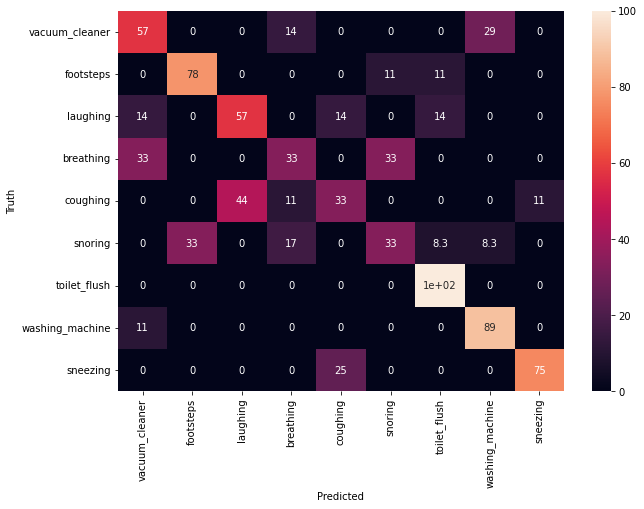

/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumo

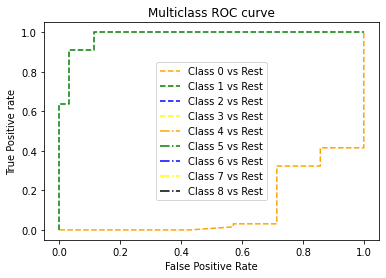

In [10]:
y_pred_etc = etc.predict(X_test) # Prediction on test data
test_acc_etc = etc.score(X_test, np.array(y_test)) # Testing accuracy
train_acc_etc = etc.score(X_train, np.array(y_train)) # Training accuracy
print("Training Accuracy: ", train_acc_etc*100,'%')
print("Testing Accuracy: ", test_acc_etc*100,'%')
con_matrix(y_pred_etc, np.array(y_test))
plot_roc(X_test, y_test, etc)

#### Random Forest Classification
Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [11]:
### Hyperparameter Tunning ###
rfc_params = {
    "n_estimators":[50, 100, 150, 200, 250, 300, 350],
    "min_samples_leaf":[1, 2, 3],
    "max_features":[1, 2, 3],
    "criterion":["gini", "entropy"]
}
ran_search_rfc = RandomizedSearchCV(RandomForestClassifier(), param_distributions = rfc_params, n_iter = 15, cv = 8, verbose = 3)
ran_search_rfc.fit(X_train, np.array(y_train))

Fitting 8 folds for each of 15 candidates, totalling 120 fits
[CV 1/8] END criterion=gini, max_features=3, min_samples_leaf=3, n_estimators=350;, score=0.583 total time=   0.4s
[CV 2/8] END criterion=gini, max_features=3, min_samples_leaf=3, n_estimators=350;, score=0.472 total time=   0.3s
[CV 3/8] END criterion=gini, max_features=3, min_samples_leaf=3, n_estimators=350;, score=0.694 total time=   0.3s
[CV 4/8] END criterion=gini, max_features=3, min_samples_leaf=3, n_estimators=350;, score=0.750 total time=   0.3s
[CV 5/8] END criterion=gini, max_features=3, min_samples_leaf=3, n_estimators=350;, score=0.583 total time=   0.3s
[CV 6/8] END criterion=gini, max_features=3, min_samples_leaf=3, n_estimators=350;, score=0.444 total time=   0.3s
[CV 7/8] END criterion=gini, max_features=3, min_samples_leaf=3, n_estimators=350;, score=0.556 total time=   0.3s
[CV 8/8] END criterion=gini, max_features=3, min_samples_leaf=3, n_estimators=350;, score=0.417 total time=   0.3s
[CV 1/8] END crite

[CV 8/8] END criterion=entropy, max_features=3, min_samples_leaf=1, n_estimators=100;, score=0.389 total time=   0.1s
[CV 1/8] END criterion=gini, max_features=2, min_samples_leaf=1, n_estimators=200;, score=0.611 total time=   0.2s
[CV 2/8] END criterion=gini, max_features=2, min_samples_leaf=1, n_estimators=200;, score=0.611 total time=   0.2s
[CV 3/8] END criterion=gini, max_features=2, min_samples_leaf=1, n_estimators=200;, score=0.750 total time=   0.2s
[CV 4/8] END criterion=gini, max_features=2, min_samples_leaf=1, n_estimators=200;, score=0.750 total time=   0.2s
[CV 5/8] END criterion=gini, max_features=2, min_samples_leaf=1, n_estimators=200;, score=0.639 total time=   0.2s
[CV 6/8] END criterion=gini, max_features=2, min_samples_leaf=1, n_estimators=200;, score=0.444 total time=   0.2s
[CV 7/8] END criterion=gini, max_features=2, min_samples_leaf=1, n_estimators=200;, score=0.556 total time=   0.2s
[CV 8/8] END criterion=gini, max_features=2, min_samples_leaf=1, n_estimators

RandomizedSearchCV(cv=8, estimator=RandomForestClassifier(), n_iter=15,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_features': [1, 2, 3],
                                        'min_samples_leaf': [1, 2, 3],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350]},
                   verbose=3)

#### Model Selection:

In [12]:
rfc = ran_search_rfc.best_estimator_ # Selecting the best model.
rfc.fit(X_train, np.array(y_train)) # Fitting the training data.

RandomForestClassifier(max_features=2, n_estimators=200)

#### Accuracy, Confusion Matrix and ROC Plot:

Training Accuracy:  1.0
Testing Accuracy:  0.6527777777777778


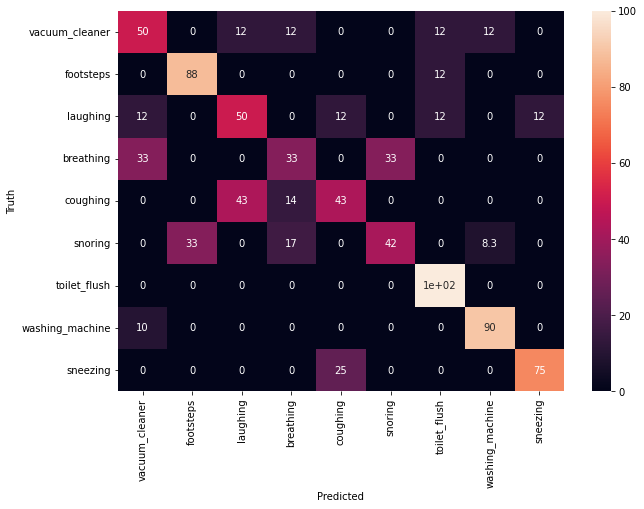

/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumo

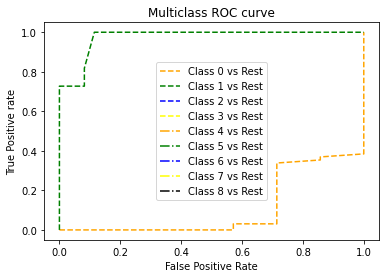

In [13]:
y_pred_rfc = rfc.predict(X_test) # Prediction on test data
test_acc_rfc = rfc.score(X_test, np.array(y_test)) # Testing accuracy
train_acc_rfc = rfc.score(X_train,  np.array(y_train)) # Training accuracy
print("Training Accuracy: ", train_acc_rfc)
print("Testing Accuracy: ", test_acc_rfc)
con_matrix(y_pred_rfc, np.array(y_test))
plot_roc(X_test, y_test, rfc)

#### Logistic Regression
Reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [14]:
lr_params = {
    "C":[1.0, 1.5, 2.0, 2.5],
    "solver" :['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    "multi_class" :['auto', 'ovr', 'multinomial']
}
ran_search_lr = RandomizedSearchCV(LogisticRegression(), param_distributions = lr_params, n_iter = 15,cv = 8,verbose = 3)
ran_search_lr.fit(X_train, np.array(y_train))

/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

Fitting 8 folds for each of 15 candidates, totalling 120 fits
[CV 1/8] END C=1.5, multi_class=auto, solver=lbfgs;, score=0.444 total time=   0.0s
[CV 2/8] END C=1.5, multi_class=auto, solver=lbfgs;, score=0.500 total time=   0.0s
[CV 3/8] END C=1.5, multi_class=auto, solver=lbfgs;, score=0.694 total time=   0.0s
[CV 4/8] END C=1.5, multi_class=auto, solver=lbfgs;, score=0.528 total time=   0.0s
[CV 5/8] END C=1.5, multi_class=auto, solver=lbfgs;, score=0.583 total time=   0.0s
[CV 6/8] END C=1.5, multi_class=auto, solver=lbfgs;, score=0.528 total time=   0.0s
[CV 7/8] END C=1.5, multi_class=auto, solver=lbfgs;, score=0.444 total time=   0.0s
[CV 8/8] END C=1.5, multi_class=auto, solver=lbfgs;, score=0.472 total time=   0.0s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

[CV 1/8] END C=1.0, multi_class=auto, solver=newton-cg;, score=0.583 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 2/8] END C=1.0, multi_class=auto, solver=newton-cg;, score=0.583 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 3/8] END C=1.0, multi_class=auto, solver=newton-cg;, score=0.694 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 4/8] END C=1.0, multi_class=auto, solver=newton-cg;, score=0.750 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 5/8] END C=1.0, multi_class=auto, solver=newton-cg;, score=0.667 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 6/8] END C=1.0, multi_class=auto, solver=newton-cg;, score=0.611 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 7/8] END C=1.0, multi_class=auto, solver=newton-cg;, score=0.472 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org

[CV 8/8] END C=1.0, multi_class=auto, solver=newton-cg;, score=0.639 total time=   0.7s
[CV 1/8] END C=1.5, multi_class=multinomial, solver=lbfgs;, score=0.444 total time=   0.0s
[CV 2/8] END C=1.5, multi_class=multinomial, solver=lbfgs;, score=0.500 total time=   0.0s
[CV 3/8] END C=1.5, multi_class=multinomial, solver=lbfgs;, score=0.694 total time=   0.0s
[CV 4/8] END C=1.5, multi_class=multinomial, solver=lbfgs;, score=0.528 total time=   0.0s
[CV 5/8] END C=1.5, multi_class=multinomial, solver=lbfgs;, score=0.583 total time=   0.0s
[CV 6/8] END C=1.5, multi_class=multinomial, solver=lbfgs;, score=0.528 total time=   0.0s
[CV 7/8] END C=1.5, multi_class=multinomial, solver=lbfgs;, score=0.444 total time=   0.0s
[CV 8/8] END C=1.5, multi_class=multinomial, solver=lbfgs;, score=0.472 total time=   0.0s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 1/8] END C=1.0, multi_class=multinomial, solver=newton-cg;, score=0.583 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 2/8] END C=1.0, multi_class=multinomial, solver=newton-cg;, score=0.583 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 3/8] END C=1.0, multi_class=multinomial, solver=newton-cg;, score=0.694 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 4/8] END C=1.0, multi_class=multinomial, solver=newton-cg;, score=0.750 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 5/8] END C=1.0, multi_class=multinomial, solver=newton-cg;, score=0.667 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 6/8] END C=1.0, multi_class=multinomial, solver=newton-cg;, score=0.611 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 7/8] END C=1.0, multi_class=multinomial, solver=newton-cg;, score=0.472 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.p

[CV 8/8] END C=1.0, multi_class=multinomial, solver=newton-cg;, score=0.639 total time=   0.7s
[CV 1/8] END C=1.5, multi_class=auto, solver=liblinear;, score=0.500 total time=   0.0s
[CV 2/8] END C=1.5, multi_class=auto, solver=liblinear;, score=0.556 total time=   0.0s
[CV 3/8] END C=1.5, multi_class=auto, solver=liblinear;, score=0.639 total time=   0.0s
[CV 4/8] END C=1.5, multi_class=auto, solver=liblinear;, score=0.778 total time=   0.0s
[CV 5/8] END C=1.5, multi_class=auto, solver=liblinear;, score=0.556 total time=   0.0s
[CV 6/8] END C=1.5, multi_class=auto, solver=liblinear;, score=0.500 total time=   0.0s
[CV 7/8] END C=1.5, multi_class=auto, solver=liblinear;, score=0.472 total time=   0.0s
[CV 8/8] END C=1.5, multi_class=auto, solver=liblinear;, score=0.639 total time=   0.0s
[CV 1/8] END C=2.0, multi_class=ovr, solver=saga;, score=0.472 total time=   0.0s
[CV 2/8] END C=2.0, multi_class=ovr, solver=saga;, score=0.500 total time=   0.0s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

[CV 3/8] END C=2.0, multi_class=ovr, solver=saga;, score=0.611 total time=   0.0s
[CV 4/8] END C=2.0, multi_class=ovr, solver=saga;, score=0.639 total time=   0.1s
[CV 5/8] END C=2.0, multi_class=ovr, solver=saga;, score=0.528 total time=   0.0s
[CV 6/8] END C=2.0, multi_class=ovr, solver=saga;, score=0.472 total time=   0.0s
[CV 7/8] END C=2.0, multi_class=ovr, solver=saga;, score=0.444 total time=   0.0s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

[CV 8/8] END C=2.0, multi_class=ovr, solver=saga;, score=0.444 total time=   0.0s
[CV 1/8] END C=2.5, multi_class=ovr, solver=saga;, score=0.472 total time=   0.0s
[CV 2/8] END C=2.5, multi_class=ovr, solver=saga;, score=0.500 total time=   0.0s
[CV 3/8] END C=2.5, multi_class=ovr, solver=saga;, score=0.611 total time=   0.0s
[CV 4/8] END C=2.5, multi_class=ovr, solver=saga;, score=0.639 total time=   0.0s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag

[CV 5/8] END C=2.5, multi_class=ovr, solver=saga;, score=0.528 total time=   0.0s
[CV 6/8] END C=2.5, multi_class=ovr, solver=saga;, score=0.472 total time=   0.0s
[CV 7/8] END C=2.5, multi_class=ovr, solver=saga;, score=0.444 total time=   0.0s
[CV 8/8] END C=2.5, multi_class=ovr, solver=saga;, score=0.444 total time=   0.0s
[CV 1/8] END C=1.0, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 2/8] END C=1.0, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 3/8] END C=1.0, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 4/8] END C=1.0, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 5/8] END C=1.0, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 6/8] END C=1.0, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 7/8] END C=1.0, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 8/8] END C=1.0, m

/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 1/8] END C=2.0, multi_class=auto, solver=newton-cg;, score=0.639 total time=   0.8s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 2/8] END C=2.0, multi_class=auto, solver=newton-cg;, score=0.583 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 3/8] END C=2.0, multi_class=auto, solver=newton-cg;, score=0.694 total time=   0.8s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 4/8] END C=2.0, multi_class=auto, solver=newton-cg;, score=0.778 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 5/8] END C=2.0, multi_class=auto, solver=newton-cg;, score=0.694 total time=   0.6s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 6/8] END C=2.0, multi_class=auto, solver=newton-cg;, score=0.611 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 7/8] END C=2.0, multi_class=auto, solver=newton-cg;, score=0.444 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/8] END C=2.0, multi_class=auto, solver=newton-cg;, score=0.667 total time=   0.8s
[CV 1/8] END C=2.5, multi_class=ovr, solver=liblinear;, score=0.472 total time=   0.0s
[CV 2/8] END C=2.5, multi_class=ovr, solver=liblinear;, score=0.556 total time=   0.0s
[CV 3/8] END C=2.5, multi_class=ovr, solver=liblinear;, score=0.611 total time=   0.0s
[CV 4/8] END C=2.5, multi_class=ovr, solver=liblinear;, score=0.778 total time=   0.0s
[CV 5/8] END C=2.5, multi_class=ovr, solver=liblinear;, score=0.583 total time=   0.0s
[CV 6/8] END C=2.5, multi_class=ovr, solver=liblinear;, score=0.500 total time=   0.0s
[CV 7/8] END C=2.5, multi_class=ovr, solver=liblinear;, score=0.472 total time=   0.0s
[CV 8/8] END C=2.5, multi_class=ovr, solver=liblinear;, score=0.639 total time=   0.0s
[CV 1/8] END C=1.5, multi_class=auto, solver=sag;, score=0.417 total time=   0.0s
[CV 2/8] END C=1.5, multi_class=auto, solver=sag;, score=0.528 total time=   0.0s
[CV 3/8] END C=1.5, multi_class=auto, solver=sag;, s

/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/8] END C=1.5, multi_class=auto, solver=sag;, score=0.528 total time=   0.0s
[CV 6/8] END C=1.5, multi_class=auto, solver=sag;, score=0.500 total time=   0.0s
[CV 7/8] END C=1.5, multi_class=auto, solver=sag;, score=0.389 total time=   0.0s
[CV 8/8] END C=1.5, multi_class=auto, solver=sag;, score=0.472 total time=   0.0s
[CV 1/8] END C=1.5, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 2/8] END C=1.5, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 3/8] END C=1.5, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 4/8] END C=1.5, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 5/8] END C=1.5, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 6/8] END C=1.5, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 7/8] END C=1.5, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 8/8] END C=1.5, m

/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 1/8] END C=1.5, multi_class=multinomial, solver=newton-cg;, score=0.556 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 2/8] END C=1.5, multi_class=multinomial, solver=newton-cg;, score=0.583 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 3/8] END C=1.5, multi_class=multinomial, solver=newton-cg;, score=0.667 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 4/8] END C=1.5, multi_class=multinomial, solver=newton-cg;, score=0.778 total time=   0.8s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 5/8] END C=1.5, multi_class=multinomial, solver=newton-cg;, score=0.694 total time=   0.8s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 6/8] END C=1.5, multi_class=multinomial, solver=newton-cg;, score=0.611 total time=   0.7s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 7/8] END C=1.5, multi_class=multinomial, solver=newton-cg;, score=0.500 total time=   0.8s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
24 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1149, in fit


[CV 8/8] END C=1.5, multi_class=multinomial, solver=newton-cg;, score=0.667 total time=   0.8s


/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


RandomizedSearchCV(cv=8, estimator=LogisticRegression(), n_iter=15,
                   param_distributions={'C': [1.0, 1.5, 2.0, 2.5],
                                        'multi_class': ['auto', 'ovr',
                                                        'multinomial'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   verbose=3)

#### Model Selection:

In [15]:
lr = ran_search_lr.best_estimator_ # Selecting the best model.
lr.fit(X_train, np.array(y_train)) # Fitting the training data.

/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


LogisticRegression(C=2.0, solver='newton-cg')

#### Accuracy, Confusion Matrix and ROC Plot:

Training Accuracy:  0.75
Testing Accuracy:  0.6805555555555556


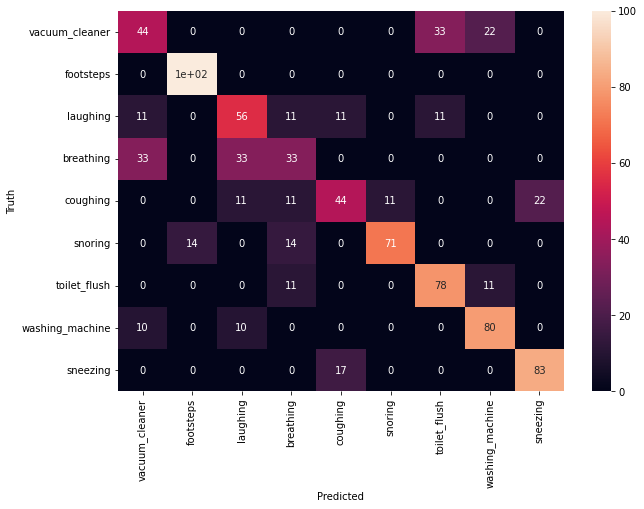

/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumo

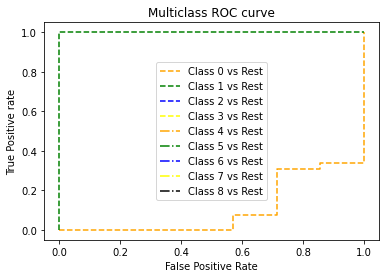

In [16]:
y_pred_lr = lr.predict(X_test) # Prediction on test data
test_acc_lr = lr.score(X_test,np.array(y_test)) # Testing accuracy
train_acc_lr = lr.score(X_train,np.array(y_train)) # Training accuracy
print("Training Accuracy: ", train_acc_lr)
print("Testing Accuracy: ", test_acc_lr)
con_matrix(y_pred_lr, np.array(y_test))
plot_roc(X_test, y_test,lr)

#### XGBRegressor
Reference: https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn

In [17]:
# xgboost
xgb_params = {
    "learning_rate":[0.05, 0.1, 0.15, 0.20, 0.25, 0.30],
    "max_depth":[3, 4, 5, 6, 7, 8, 10, 12, 15],
    "min_child_weight":[1, 3, 5, 7],
    "n_estimators":[50, 100, 120, 150],
    "gamma":[0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree":[0.3, 0.4, 0.5, 0.7]
}

ran_search_xgb = RandomizedSearchCV(XGBClassifier(), param_distributions = xgb_params, n_iter = 15, cv = 8, verbose = 3)
ran_search_xgb.fit(X_train, np.array(y_train))

Fitting 8 folds for each of 15 candidates, totalling 120 fits
[CV 1/8] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=100;, score=0.611 total time=   0.6s
[CV 2/8] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=100;, score=0.528 total time=   0.6s
[CV 3/8] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=100;, score=0.778 total time=   0.5s
[CV 4/8] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=100;, score=0.667 total time=   0.5s
[CV 5/8] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=100;, score=0.611 total time=   0.5s
[CV 6/8] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=100;, score=0.500 total time=   0.7s
[CV 7/8] END colsample_bytree=0.4, gamma=0.2

[CV 8/8] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.3, max_depth=10, min_child_weight=7, n_estimators=150;, score=0.556 total time=   0.6s
[CV 1/8] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=120;, score=0.611 total time=   0.5s
[CV 2/8] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=120;, score=0.500 total time=   0.4s
[CV 3/8] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=120;, score=0.778 total time=   0.8s
[CV 4/8] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=120;, score=0.722 total time=   0.4s
[CV 5/8] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=120;, score=0.583 total time=   0.5s
[CV 6/8] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estim

[CV 8/8] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=100;, score=0.528 total time=   0.7s
[CV 1/8] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=120;, score=0.639 total time=   0.5s
[CV 2/8] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=120;, score=0.528 total time=   0.5s
[CV 3/8] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=120;, score=0.778 total time=   0.6s
[CV 4/8] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=120;, score=0.694 total time=   0.5s
[CV 5/8] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=120;, score=0.611 total time=   0.5s
[CV 6/8] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estim

RandomizedSearchCV(cv=8,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=15,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [50, 100, 120, 150]},
                   verbose=3)

#### Model Selection:

In [18]:
xgb = ran_search_xgb.best_estimator_ # Selecting the best model.
xgb.fit(X_train, np.array(y_train)) # Fitting the training data.

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=120,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

#### Accuracy, Confusion Matrix and ROC Plot:

Training Accuracy:  0.9618055555555556
Testing Accuracy:  0.6527777777777778


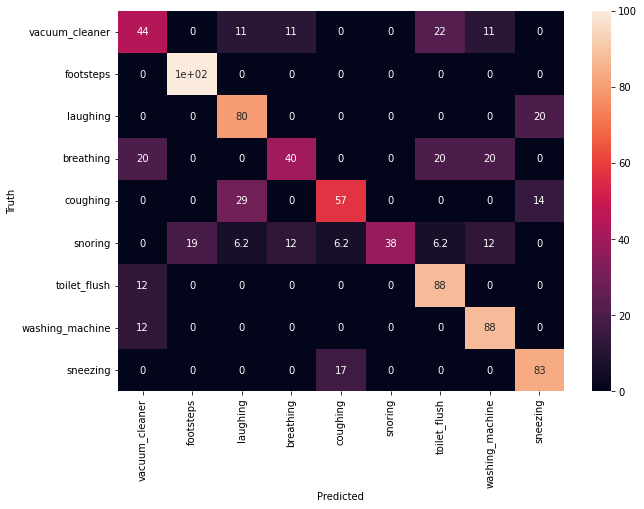

/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumon/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sumo

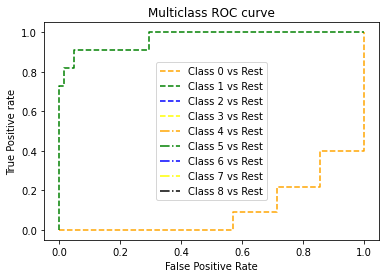

In [19]:
y_pred_xgb = xgb.predict(X_test) # Prediction on test data
test_acc_xgb = xgb.score(X_test, np.array(y_test)) # Testing accuracy
train_acc_xgb = xgb.score(X_train, np.array(y_train)) # Training accuracy
print("Training Accuracy: ", train_acc_xgb)
print("Testing Accuracy: ", test_acc_xgb)
con_matrix(y_pred_xgb, np.array(y_test))
plot_roc(X_test, y_test, xgb)

### Evaluation

In [20]:
df_evl = pd.DataFrame()
df_evl["Algorithm"]=["Extra Tree Classification", "Random Forest Classification", "Logistic Regression", "XGBoost Regression"]
df_evl["Training Accuracy"] = [train_acc_etc, train_acc_rfc, train_acc_lr, train_acc_xgb]
df_evl["Testing Accuracy"] = [test_acc_etc, test_acc_rfc, test_acc_lr, test_acc_xgb]
df_evl

,Algorithm,Training Accuracy,Testing Accuracy
0,Extra Tree Classification,1.000000,0.625000
1,Random Forest Classification,1.000000,0.652778
2,Logistic Regression,0.750000,0.680556
3,XGBoost Regression,0.961806,0.652778


### Validation - Predicting Classes from random Audio Files

In [21]:
def predict(name, model):
  # Creating input vectror from the data
  # Extracting Spectrum Features
  pre_spectrum_features=[]
  hf =h5py.File(AED_C_dir+'/tracts/'+name+'.hdf5', 'r')
  S_E = np.array(hf.get('E'))
  Spt_E=Spectral_Centroids=librosa.feature.spectral_centroid(S=S_E, freq=np.linspace(0, 1, num=S_E.shape[0]))
  if Spt_E.shape[1]!=8498:
      Spt_E=np.hstack((Spt_E,[[0]*(8498-Spt_E.shape[1])]))
  S_f_tract= np.array(hf.get('f_tract'))
  Spt_f=Spectral_Centroids=librosa.feature.spectral_centroid(S=S_f_tract, freq=np.linspace(0, 1, num=S_E.shape[0]))
  if Spt_f.shape[1]!=8498:
      Spt_f=np.hstack((Spt_f,[[0]*(8498-Spt_f.shape[1])]))
  S_s_tract= np.array(hf.get('s_tract'))
  Spt_s=Spectral_Centroids=librosa.feature.spectral_centroid(S=S_f_tract, freq=np.linspace(0, 1, num=S_E.shape[0]))
  if Spt_s.shape[1]!=8498:
      Spt_s=np.hstack((Spt_s,[[0]*(8498-Spt_s.shape[1])]))
  mean=[np.mean(Spt_E),np.mean(Spt_s),np.mean(Spt_f)]
  min=[np.min(Spt_E),np.min(Spt_s),np.min(Spt_f)]
  max=[np.max(Spt_E),np.max(Spt_s),np.max(Spt_f)]
  pre_spectrum_features.append(mean+min+max)
  pre_spectrum_features=np.array(pre_spectrum_features)

  # Extracting PTNE Features
  pre_ptne_features=[]
  hf =h5py.File(AED_C_dir+'/ptne/'+name+'.hdf5', 'r')
  energy=np.array(hf.get('energy'))
  noise=np.array(hf.get('noise'))
  pulse=np.array(hf.get('pulse'))
  tone=np.array(hf.get('tone'))
  energy_features=[np.mean(energy),np.min(energy),np.max(energy)]
  noise_features=[np.mean(noise),np.min(noise),np.max(noise)]
  pulse_features=[np.mean(pulse),np.min(pulse),np.max(pulse)]
  tone_features=[np.mean(tone),np.min(tone),np.max(tone)]
  pre_ptne_features.append(energy_features+noise_features+pulse_features+tone_features)
  pre_ptne_features=np.array(pre_ptne_features)
  X=np.hstack((pre_spectrum_features,pre_ptne_features))
  
  # Class Prediction from the Audio File
  out=classes[model.predict(X)[0]]
  return(out)

#### Displaying Metadata for Class Prediction

In [22]:
meta_data

,Unnamed: 0,filename,fold,target,category,esc10,src_file,take
0,3,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
1,4,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
2,40,1-155858-A-25.wav,1,25,footsteps,False,155858,A
3,41,1-155858-B-25.wav,1,25,footsteps,False,155858,B
4,42,1-155858-C-25.wav,1,25,footsteps,False,155858,C
...,...,...,...,...,...,...,...,...
355,1992,5-263501-A-25.wav,5,25,footsteps,False,263501,A
356,1993,5-263775-A-26.wav,5,26,laughing,False,263775,A
357,1994,5-263775-B-26.wav,5,26,laughing,False,263775,B
358,1997,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A


In [23]:
predict('1-100210-A-36', etc)

'vacuum_cleaner'

In [24]:
predict('1-100210-B-36', etc)

'vacuum_cleaner'

In [25]:
predict('1-155858-A-25', etc)

'footsteps'